In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

# Load the datasets

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets to create a comprehensive dataset

In [3]:
merged_data = transactions.merge(customers, on='CustomerID')

# Feature Engineering
# Create a pivot table to summarize transaction history

In [4]:
transaction_summary = merged_data.groupby(['CustomerID']).agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'ProductID': 'nunique'
}).reset_index()

# Rename columns for clarity
transaction_summary.rename(columns={
    'TotalValue': 'TotalSpent',
    'Quantity': 'TotalQuantity',
    'ProductID': 'UniqueProducts'
}, inplace=True)

# Merge back with customer data to include customer features

In [5]:
customer_features = customers.merge(transaction_summary, on='CustomerID', how='left').fillna(0)

# Select relevant features for clustering
features = customer_features[['TotalSpent', 'TotalQuantity', 'UniqueProducts']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the Elbow Method

In [8]:
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

inertia = []
silhouette_scores = []
db_indices = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))
    db_indices.append(davies_bouldin_score(scaled_features, kmeans.labels_))


# Plotting the Elbow Method

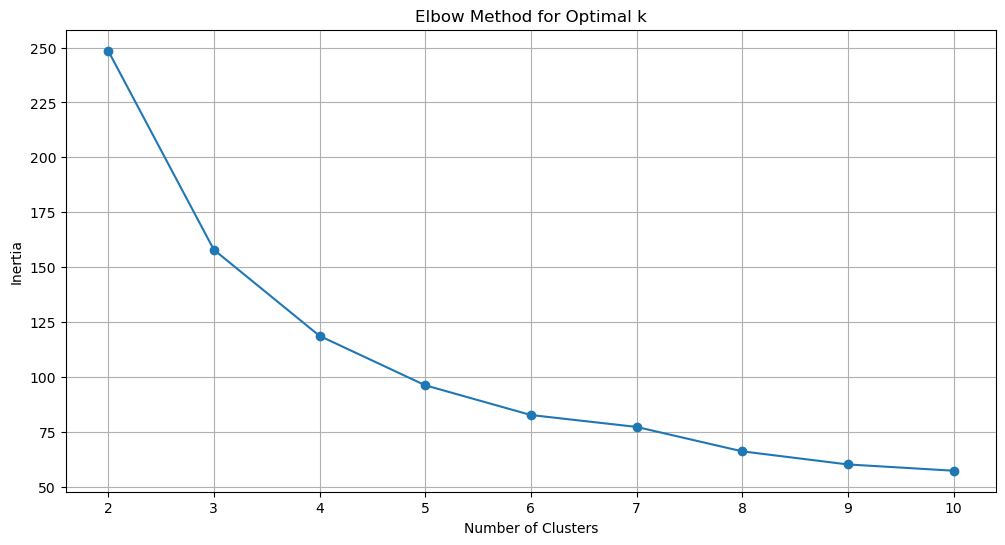

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# Plotting the Silhouette Scores

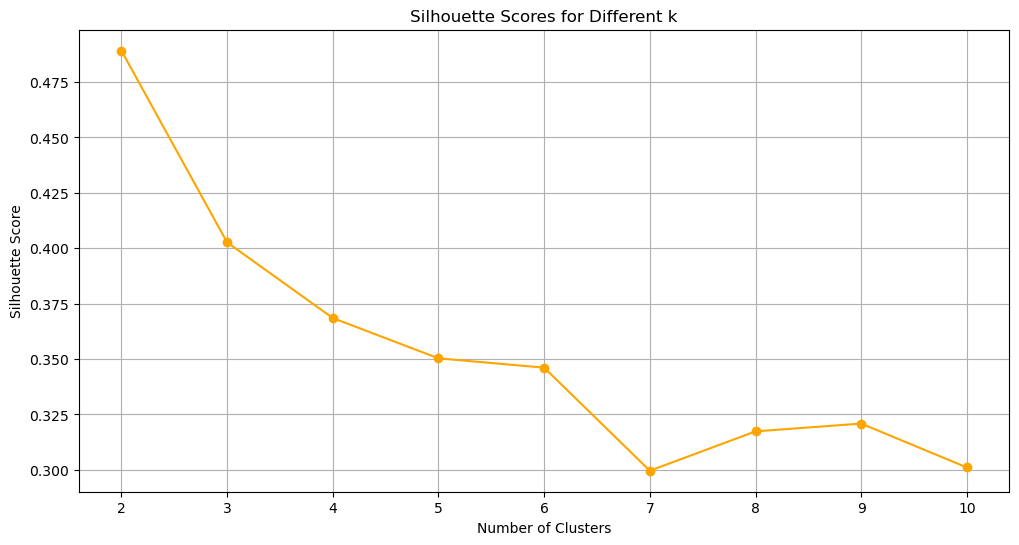

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

# Plotting the DB Index

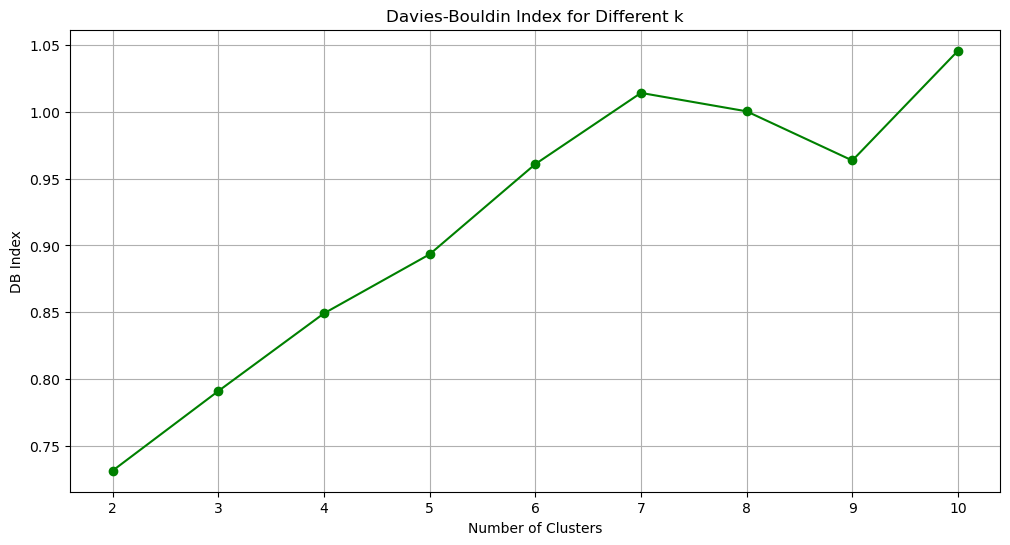

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), db_indices, marker='o', color='green')
plt.title('Davies-Bouldin Index for Different k')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.grid()
plt.show()

# Choosing the optimal number of clusters (let's say we choose 4 based on the elbow method)

In [12]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(scaled_features)

# Adding cluster labels to the customer features
customer_features['Cluster'] = kmeans.labels_

# Visualizing the clusters using PCA for dimensionality reduction

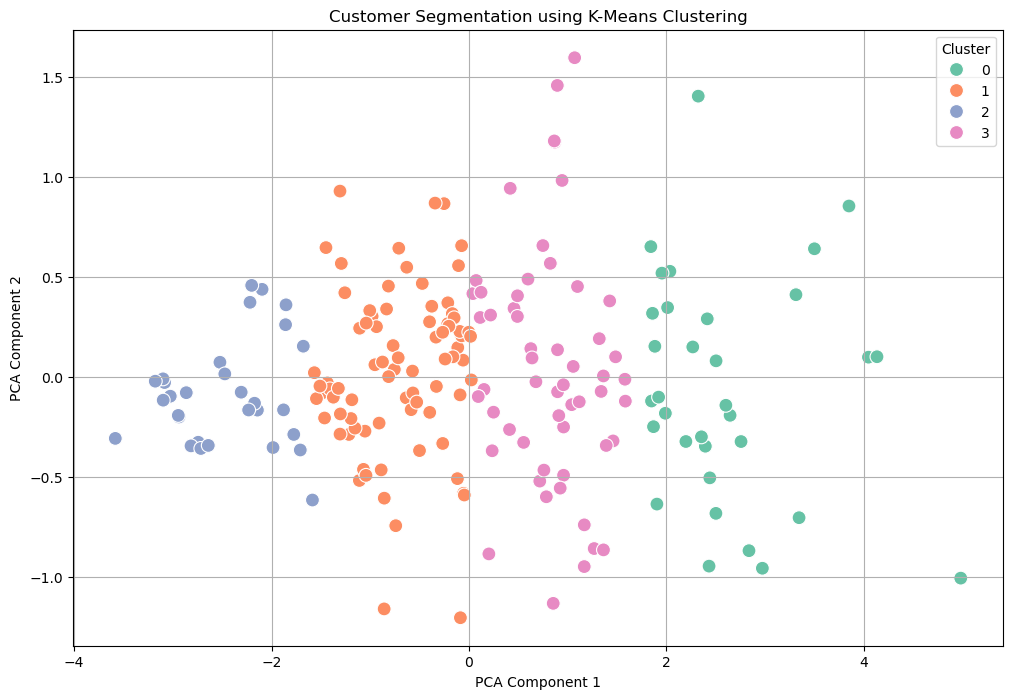

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=customer_features['Cluster'], palette='Set2', s=100)
plt.title('Customer Segmentation using K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# Calculate the DB Index for the chosen clusters

In [14]:

db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f'Number of Clusters: {optimal_clusters}')
print(f'Davies-Bouldin Index: {db_index:.4f}')

Number of Clusters: 4
Davies-Bouldin Index: 0.8492


In [24]:
customer_features = customers.merge(transaction_summary, on='CustomerID', how='left').fillna(0)

# Select relevant features for clustering
features = customer_features[['TotalSpent', 'TotalQuantity', 'UniqueProducts']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# DBSCAN Clustering

In [19]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_features)

# Adding cluster labels to the customer features
customer_features['DBSCAN_Cluster'] = dbscan_labels

# Calculate metrics
if len(set(dbscan_labels)) > 1:  # Ensure there are at least 2 clusters
    db_index_dbscan = davies_bouldin_score(scaled_features, dbscan_labels)
    silhouette_dbscan = silhouette_score(scaled_features, dbscan_labels)
    calinski_dbscan = calinski_harabasz_score(scaled_features, dbscan_labels)
else:
    db_index_dbscan = silhouette_dbscan = calinski_dbscan = None

print(f'DBSCAN Clustering: DB Index: {db_index_dbscan}, Silhouette Score: {silhouette_dbscan}, Calinski-Harabasz Index: {calinski_dbscan}')

DBSCAN Clustering: DB Index: 1.7456126658329436, Silhouette Score: 0.3290801318646411, Calinski-Harabasz Index: 27.66920340370391


# Agglomerative Clustering

In [20]:
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(scaled_features)

# Adding cluster labels to the customer features
customer_features['Agglo_Cluster'] = agglo_labels

# Calculate metrics
db_index_agglo = davies_bouldin_score(scaled_features, agglo_labels)
silhouette_agglo = silhouette_score(scaled_features, agglo_labels)
calinski_agglo = calinski_harabasz_score(scaled_features, agglo_labels)

print(f'Agglomerative Clustering: DB Index: {db_index_agglo:.4f}, Silhouette Score: {silhouette_agglo:.4f}, Calinski-Harabasz Index: {calinski_agglo:.4f}')

Agglomerative Clustering: DB Index: 0.9214, Silhouette Score: 0.3357, Calinski-Harabasz Index: 235.6878


# Visualizing K-Means Clusters in 2D

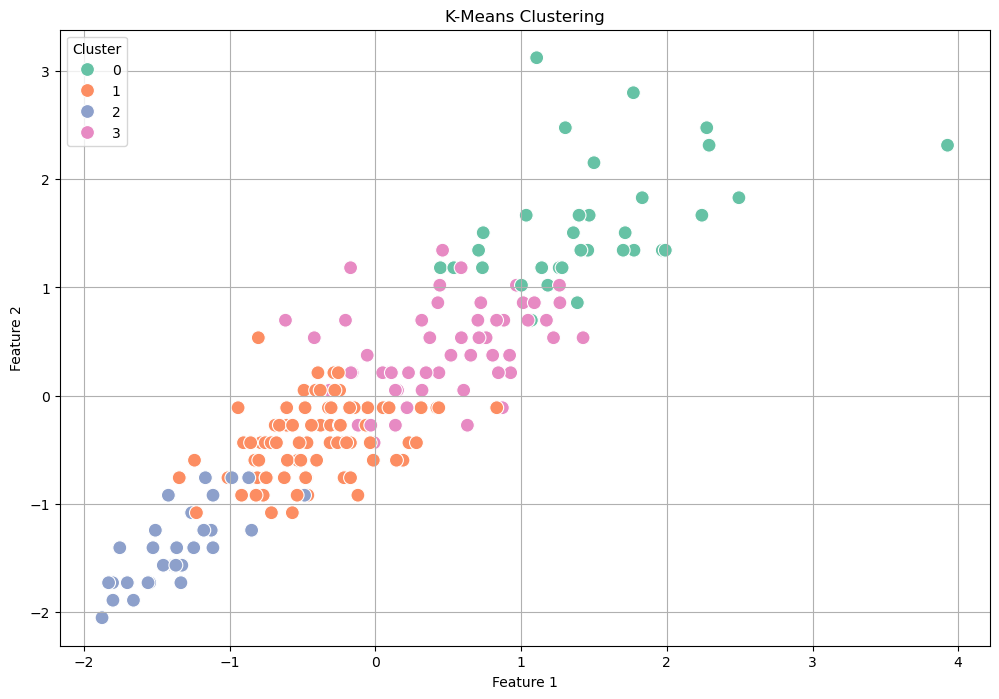

In [21]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=customer_features['KMeans_Cluster'], palette='Set2', s=100)
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# Visualizing K-Means Clusters in 3D

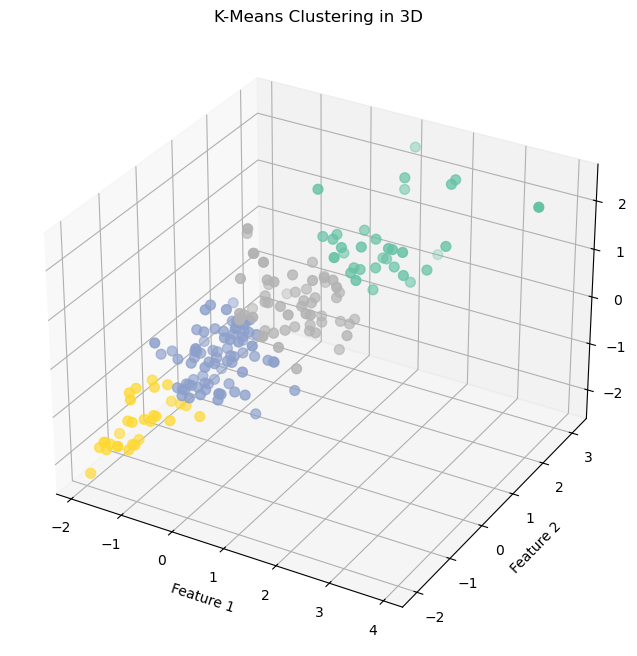

In [22]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scaled_features[:, 0], scaled_features[:, 1], scaled_features[:, 2], c=customer_features['KMeans_Cluster'], cmap='Set2', s=50)
ax.set_title('K-Means Clustering in 3D')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()